# Linear Regression  on a Combined Cycle Power Plant (CCPP) data

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluting your notebook!!!

## Dataset description

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP)  of the plant.

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In [2]:
# to get in-line plots
%matplotlib nbagg
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import stats

## Import Data
Load the data from a .csv file

**TO DO:** insert your ID number (matricola)


In [3]:
# Load the data
IDnumber = 1184444
np.random.seed(IDnumber)

filename = "data/ccpp_Data_clean.csv"

Data = np.genfromtxt(filename, delimiter=';',skip_header=1)


# A quick overview of data

To inspect the data you can use the method describe()

In [4]:
dataDescription = stats.describe(Data)
print(dataDescription)

Data.shape

#for more interesting visualization: use Panda!

DescribeResult(nobs=5569, minmax=(array([  1.81,  25.36, 992.89,  25.56, 420.26]), array([  37.11,   81.56, 1033.29,  100.16,  495.23])), mean=array([  19.69058718,   54.40303106, 1013.23446938,   73.45975938,
        454.24340995]), variance=array([ 55.98196307, 162.34200884,  35.02111826, 216.28607983,
       292.02539227]), skewness=array([-0.14554816,  0.18454044,  0.25458028, -0.43996361,  0.30989023]), kurtosis=array([-1.03836314, -1.45181284,  0.03996015, -0.42670395, -1.04830196]))


(5569, 5)

# Split data in training, validation and test sets



Given $m$ total data, keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$. For instance one can take $m_t=m/3$ of the data as training, $m_{val}=m/3$  validation and $m_{test}=m/3$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: When different model classes are present (e.g. of different complexity such as linear regression which uses a different number $d_j$ of regressors $x_1$,...$x_{d_j}$), one has to choose which one is the "best" complexity. 
Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d_j: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$


**TO DO**: split the data in training, validation and test sets (suggestion: use $m_t=m_{val} = \lfloor\frac{m}{3}\rfloor$, $m_{test} = m-m_t-m_{val}$)

In [5]:
#get number of total samples
num_total_samples = Data.shape[0]

print("Total number of samples: ", num_total_samples)

#size of each chunk of data for training, validation, testing
size_chunk = int (num_total_samples/3)
print("Size of each chunk of data: ", size_chunk)

#shuffle the data
np.random.shuffle(Data)


#training data  

m_training = m_validation = size_chunk
m_test = num_total_samples-2*m_training

X_training = Data[:m_training,:-1]
Y_training = Data[:m_training,-1:]
print("Training input data size: ", X_training.shape)
print("Training output data size: ", Y_training.shape)

#validation data, to be used to choose among different models
X_validation = Data[m_training:m_training+m_validation,:-1]
Y_validation = Data[m_training:m_training+m_validation,-1:]
print("Validation input data size: ", X_validation.shape)
print("Validation output data size: ", Y_validation.shape)

#test data, to be used to estimate the true loss of the final model(s)
X_test = Data[-m_test:,:-1]
Y_test = Data[-m_test:,-1:]
print("Test input data size: ", X_test.shape)
print("Test output data size: ", Y_test.shape)

Total number of samples:  5569
Size of each chunk of data:  1856
Training input data size:  (1856, 4)
Training output data size:  (1856, 1)
Validation input data size:  (1856, 4)
Validation output data size:  (1856, 1)
Test input data size:  (1857, 4)
Test output data size:  (1857, 1)


# Data Normalization

It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to $1$. This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients. 

In [6]:
#scale the data

# standardize the input matrix
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_training)
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))
X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print ("Mean of the validation input data:", X_validation.mean(axis=0))
print ("Std of the validation input data:", X_validation.std(axis=0))
X_test = scaler.transform(X_test) # use the same transformation on test data
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))



Mean of the training input data: [ 2.60890447e-15  1.35296468e-15 -7.86918423e-14  3.83690924e-15]
Std of the training input data: [1. 1. 1. 1.]
Mean of the validation input data: [-0.00445358  0.00756265  0.017554    0.01559851]
Std of the validation input data: [1.00256685 1.01131768 1.05004539 0.99694227]
Mean of the test input data: [-0.02435032 -0.04495978  0.03894389  0.03335192]
Std of the test input data: [0.98950026 0.98749189 1.02030696 0.98676809]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.


 **TO DO:** compute the linear regression coefficients implementing the least square algorithm as done in Lab0 and using np.linalg.lstsq from scikitlear 

In [7]:
#compute linear regression coefficients for training data

#add a 1 at the beginning of each sample for training, validation, and testing

X_training = np.hstack((np.ones((m_training,1)),X_training))
#print X_training[0,:]

X_validation = np.hstack((np.ones((m_validation,1)),X_validation))
#print X_validation[0,:]

X_test = np.hstack((np.ones((m_test,1)),X_test))
#print X_test[0,:]


# Compute the least-squares solution using the same approach of LAB0
X_training_Tr = np.transpose(X_training)

#compute matrix A and vector b
A = np.dot(X_training_Tr, X_training)
b = np.dot(X_training_Tr, Y_training)

#manual computation
w_hand = np.dot(np.linalg.inv(A), b)


# Compute the least-squares coefficients using linalg.lstsq

w_np, RSStr_np, rank_Xtr, sv_Xtr = np.linalg.lstsq(X_training,Y_training)

print("LS coefficients by hand:", w_hand)

print("LS coefficients with numpy lstsq:", w_np)

# compute Residual sums of squares by hand

RSStr_hand = np.sum(np.power(Y_training-np.dot(X_training,w_hand),2),0)

print("RSS by hand:",  RSStr_hand)
print("RSS with numpy lstsq: ", RSStr_np)

print("Empirical risk by hand:", RSStr_hand/m_training)
print("Empirical risk with numpy lstsq:", RSStr_np/m_training)



LS coefficients by hand: [[ 4.54006573e+02]
 [-1.45892900e+01]
 [-3.26597110e+00]
 [ 3.45536618e-01]
 [-2.35026050e+00]]
LS coefficients with numpy lstsq: [[ 4.54006573e+02]
 [-1.45892900e+01]
 [-3.26597110e+00]
 [ 3.45536618e-01]
 [-2.35026050e+00]]
RSS by hand: [38820.85771655]
RSS with numpy lstsq:  [38820.85771655]
Empirical risk by hand: [20.91641041]
Empirical risk with numpy lstsq: [20.91641041]


/home/giangi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS) defined above, the Emprical Loss and the quantity $1-R^2$ where
$$
R^2 = \frac{\sum_{z_i \in S_t} (\hat y_i - \bar y)^2}{\sum_{z_i \in S_t} (y_i - \bar y)^2} \quad \quad \bar y = \frac{1}{m_t} \sum_{z_i \in S_t} y_i
$$
is the so-called "Coefficient of determination" (COD)

**TO DO**: Compute these quantities on  training, validation and test sets.


In [8]:
#compute predictions on training and validation
prediction_training = np.dot(X_training, w_hand)
prediction_validation = np.dot(X_validation, w_hand)
prediction_test = np.dot(X_test, w_hand)

#what about the loss for points in the validation data?
RSS_validation = np.dot(np.transpose(Y_validation - prediction_validation),Y_validation - prediction_validation)
RSS_test = np.dot(np.transpose(Y_test - prediction_test),Y_test - prediction_test)

print("RSS on validation data:",  RSS_validation)
print("Loss estimated from validation data:", RSS_validation/m_validation)

#another measure of how good our linear fit is given by the following (that is 1 - R^2)
#useful function to compute in a more compact form
def R_SQ(x,y):
    m = np.mean(x)
    y_diff = y - m
    x_diff = x - m
    R2 = np.array(np.dot(np.transpose(y_diff),y_diff)/np.dot(np.transpose(x_diff),x_diff))
    return 1 - R2
Rmeasure_training = R_SQ(Y_training, prediction_training)
Rmeasure_validation = R_SQ(Y_validation, prediction_validation)
Rmeasure_test = R_SQ(Y_test, prediction_test)

print("Measure on Training Data (1-R^2):", Rmeasure_training)
print("Measure on Validation Data(1-R^2):", Rmeasure_validation)
print("Measure on Test Data(1-R^2):", Rmeasure_test)

RSS on validation data: [[38765.37292946]]
Loss estimated from validation data: [[20.88651559]]
Measure on Training Data (1-R^2): [[0.07090177]]
Measure on Validation Data(1-R^2): [[0.05458098]]
Measure on Test Data(1-R^2): [[0.07791715]]


## ... and plot:


### (1) output predictions on training  data

<IPython.core.display.Javascript object>


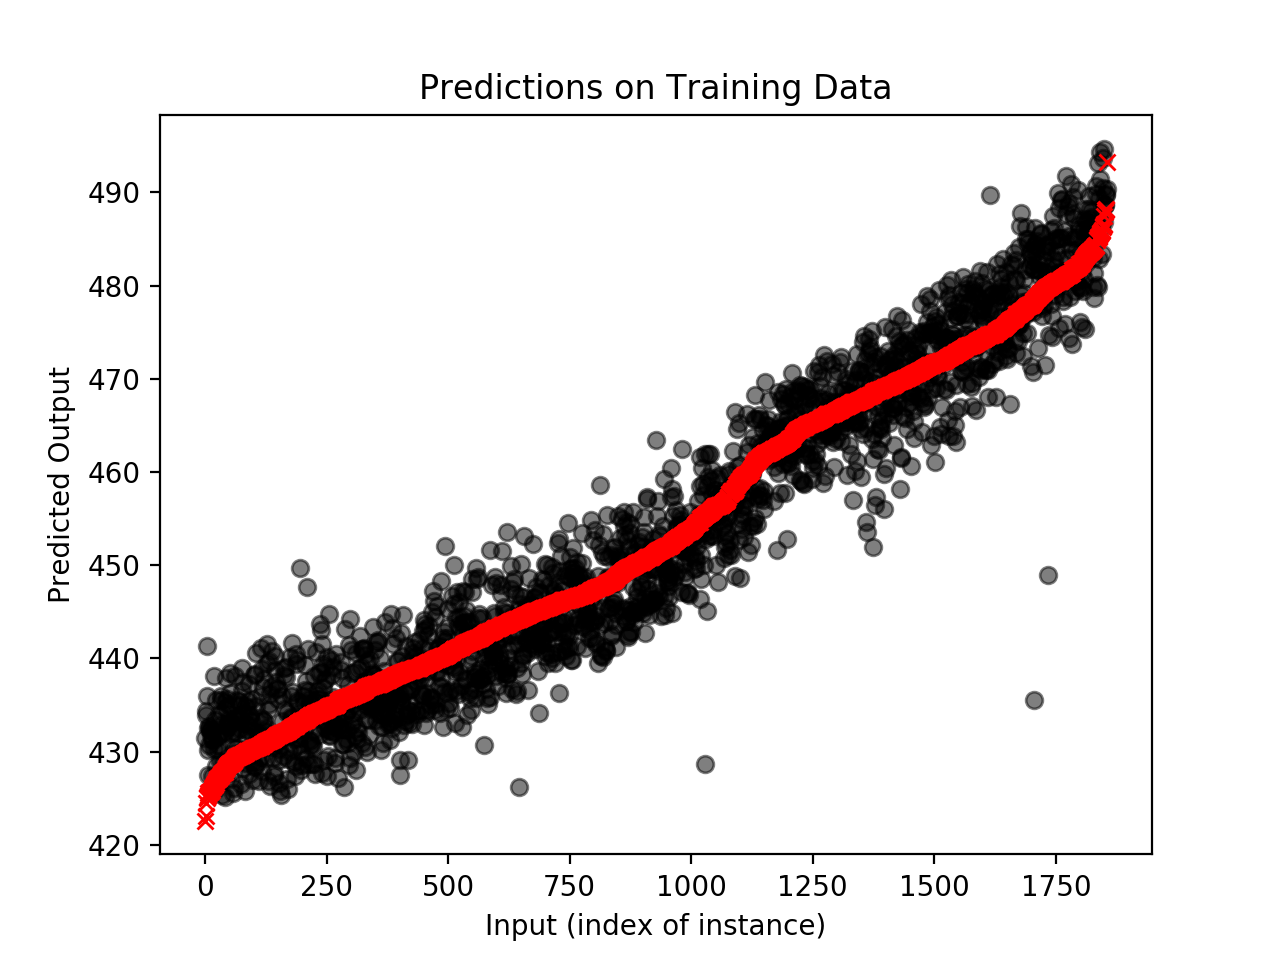

In [9]:
# Plot predictions on Training data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_training[0:m_training])), key=lambda k: prediction_training[0:m_training][k])
plt.plot(Y_training[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_training[sorting_permutation], 'rx')

plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Training Data')
plt.show()

### (2) output predictions on validation  data

<IPython.core.display.Javascript object>


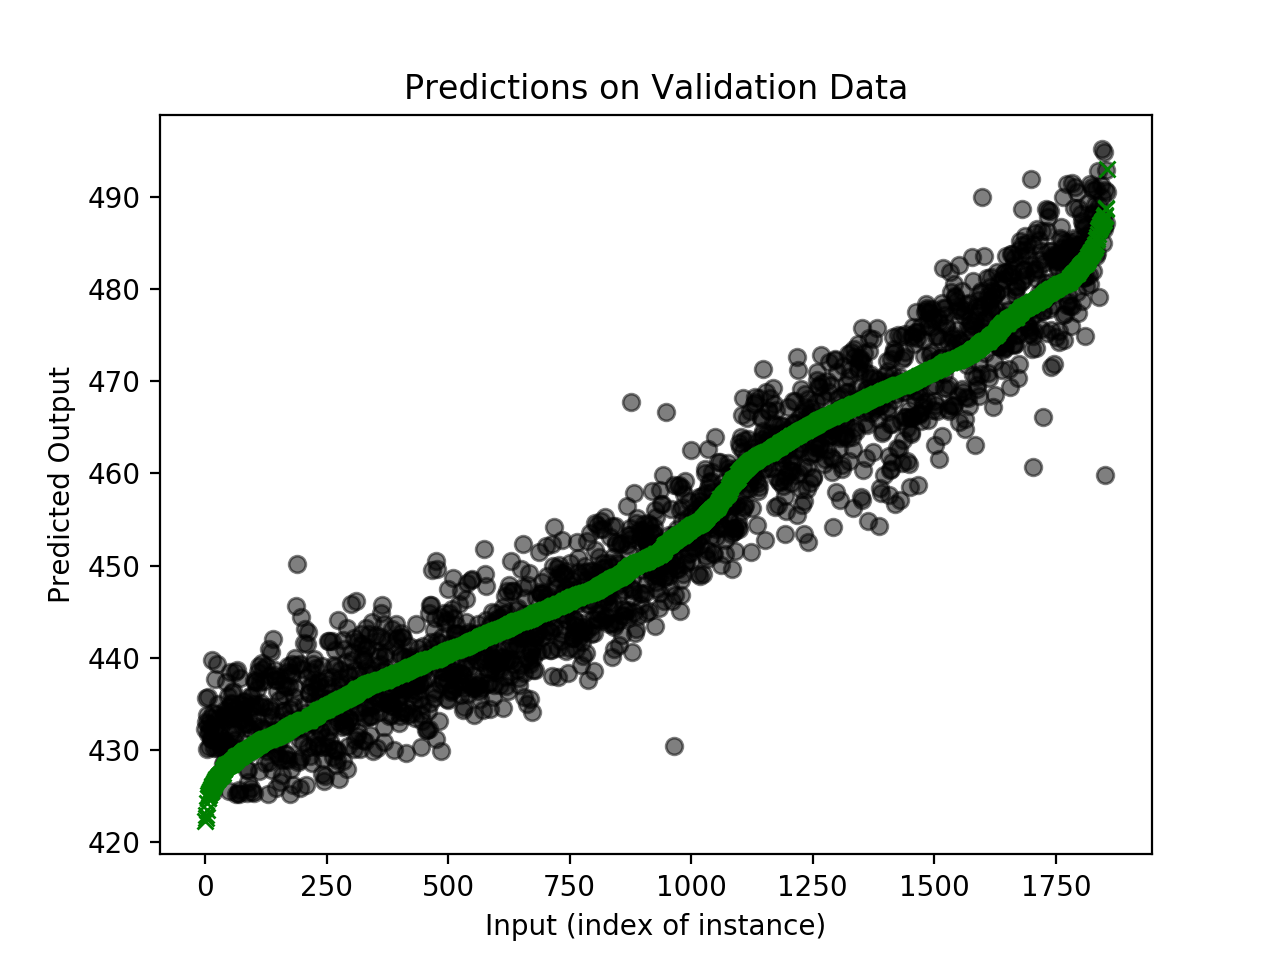

In [10]:
# Plot predictions on validation data 
plt.figure()

#the following is just for nice plotting, not required: it sorts the predictions by value so that they fall on
# a line and it's easier to spot the differences
sorting_permutation = sorted(range(len(prediction_validation[0:m_validation])), key=lambda k: prediction_validation[0:m_validation][k])
plt.plot(Y_validation[sorting_permutation], 'ko', alpha=0.5)
plt.plot(prediction_validation[sorting_permutation], 'gx')


plt.xlabel('Input (index of instance)')
plt.ylabel('Predicted Output')
plt.title('Predictions on Validation Data')
plt.show()

## Visualization:  3D plot with fitted hyperplane (only w.r.t. 2 regressors) for training set

To the purpose of visualization we plot the linear function only w.r.t. the first 2 variables (of course any other choice could be made)

<IPython.core.display.Javascript object>


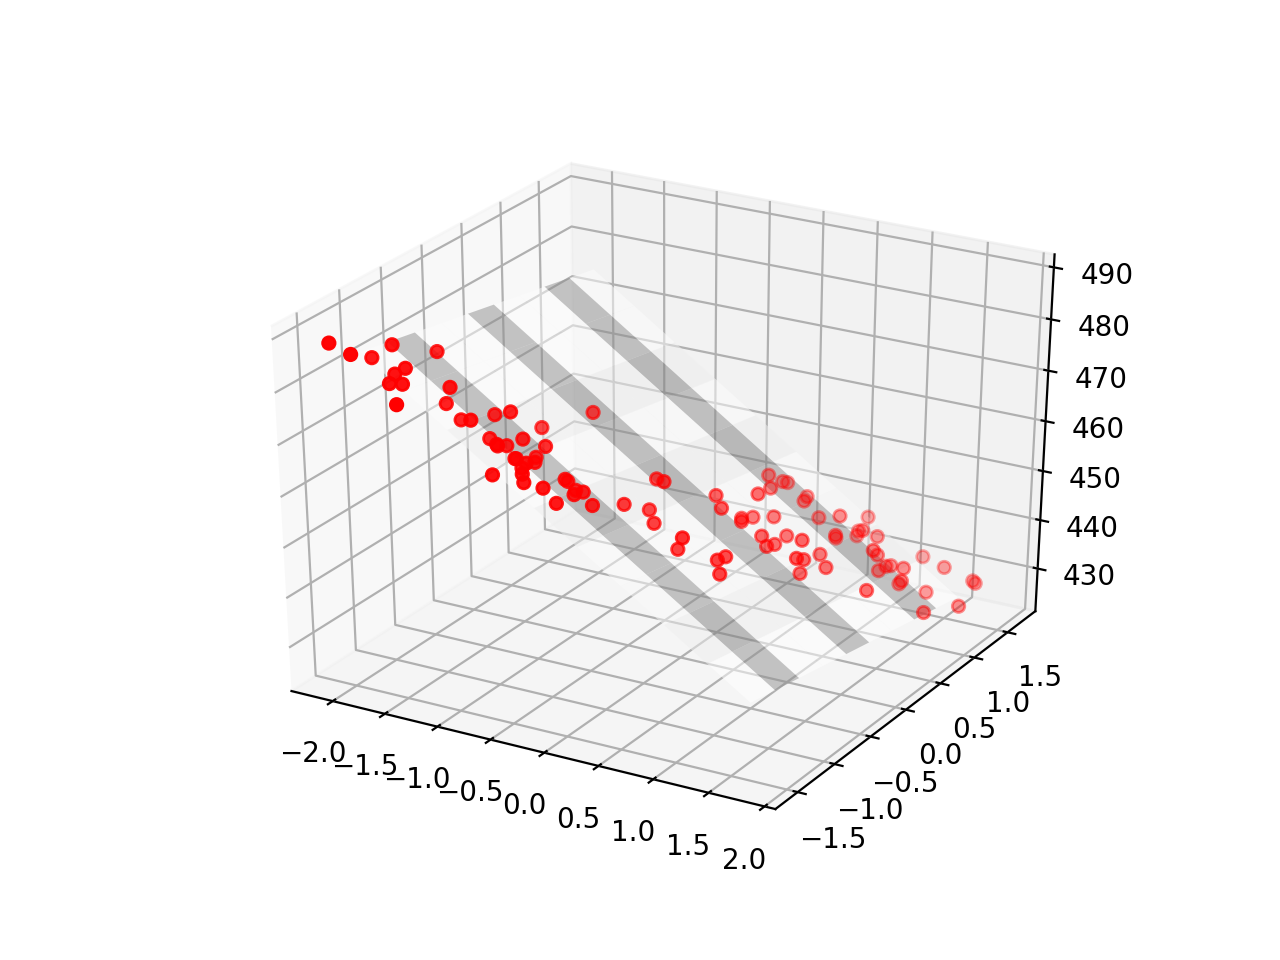

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
#plot only m=100 points
m = 100
x1 = X_training[0:m-1,1]
x2 = X_training[0:m-1,2]
ax.scatter(x1,x2,prediction_training[0:m-1], c='r')

#generate a meshgrid to be used to plot surface

#n = number of points to be used in the grid
n=10
x1_surf = np.arange(0.9*min(x1), 1.1*max(x1), (1.1*max(x1)-0.9*min(x1))/n)
x2_surf = np.arange(0.9*min(x2), 1.1*max(x2), (1.1*max(x2)-0.9*min(x2))/n)                

# generate a mesh
x1_surf, x2_surf = np.meshgrid(x1_surf, x2_surf)

#get corresponding input and then the predicted output from linear regression model
x_surf = np.hstack((np.ones((n*n,1)),list(zip( x1_surf.ravel(),x2_surf.ravel()  ))))
y_surf = np.dot(x_surf,w_np[:3])

ax.plot_surface(x1_surf,x2_surf,y_surf.reshape(n,n), alpha=0.5, color=[1,1,1])

plt.show()

## Ordinary Least-Squares using scikit-learn

A fast way to compute the LS estimate is through sklearn.linear_model

In [12]:
# Remove the ``ones'' column in the features matrix (sklearn inserts it automatically)
X_training = X_training[:,1:]
X_test = X_test[:,1:]


In [13]:
from sklearn import linear_model
LinReg = linear_model.LinearRegression()  # build the object LinearRegression
LinReg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)
prediction_training = LinReg.predict(X_training)  # predict output values on training set
prediction_test = LinReg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))


Intercept: [454.00657328]
Least-Squares Coefficients: [[-14.58929003  -3.2659711    0.34553662  -2.3502605 ]]
Measure on training data: 0.07090176798477055
